<a href="https://colab.research.google.com/github/renyuanL/110_project/blob/main/_ry_Google_Stock_Price_Prediction_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LSTM that predicts upwards and downwards trend of google stockprice 
Many layers with dropout regularisation to prevent overfitting

Part 1 - Data Preprocessing

In [24]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import pandas_datareader as pdr 
from  sklearn.preprocessing import MinMaxScaler


In [160]:
dataset_train= pdr.get_data_yahoo('^GSPC', 
                   start='1980-01-01', 
                   end= '2015-01-01'
                   )['Close']

dataset_test= pdr.get_data_yahoo('^GSPC', 
                  start='2014-12-01', 
                  end= '2021-01-01'
                  )['Close']

dataset_train.size, dataset_test.size

(8829, 1533)

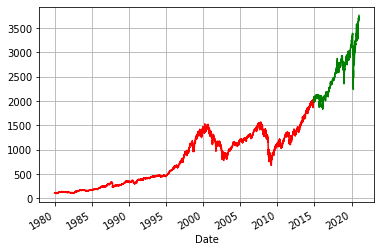

In [161]:
dataset_train.plot(grid=True, c='r')
dataset_test.plot(grid=True,  c='g')

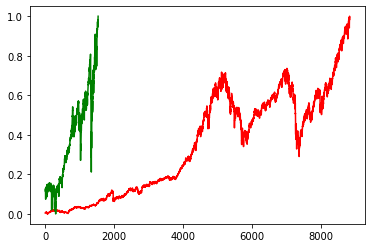

In [162]:

training_set= dataset_train.values
training_set= training_set.reshape(-1,1)

test_set= dataset_test.values
test_set= test_set.reshape(-1,1)

sc= MinMaxScaler(feature_range= (0, 1))
training_set_scaled= sc.fit_transform(training_set) 
test_set_scaled=   sc.fit_transform(test_set) 

plt.plot(training_set_scaled,c='r')
plt.plot(test_set_scaled,c='g')


In [163]:
X_train= []
y_train= []
N= training_set_scaled.size
waitingDays= 30

for i in range(waitingDays, N): # upper bound is number of values 
  X_train.append(training_set_scaled[i-waitingDays:i, 0]) #takes 60 previous stock prices from 60 past stock prices
  y_train.append(training_set_scaled[i, 0]) #contains stock price learned to predict 
X_train, y_train= np.array(X_train), np.array(y_train) # make into numpy arrays 
X_train, y_train


#Need to add dimension to because not only prescition with one stock price but other indicators (like other columns in dataset  or other stocks that may affect this one )

(array([[0.00378448, 0.00351344, 0.00416593, ..., 0.00990288, 0.00948629,
         0.00987778],
        [0.00351344, 0.00416593, 0.00431149, ..., 0.00948629, 0.00987778,
         0.01014882],
        [0.00416593, 0.00431149, 0.0053856 , ..., 0.00987778, 0.01014882,
         0.00928552],
        ...,
        [0.97428157, 0.97452751, 0.97528039, ..., 0.9957838 , 0.99563822,
         0.99909652],
        [0.97452751, 0.97528039, 0.98054056, ..., 0.99563822, 0.99909652,
         1.        ],
        [0.97528039, 0.98054056, 0.97899461, ..., 0.99909652, 1.        ,
         0.99487039]]),
 array([0.01014882, 0.00928552, 0.008628  , ..., 1.        , 0.99487039,
        0.98410412]))

In [164]:
# Reshaping- add dimension in numpy array 
X_train= np.reshape(X_train, 
           (X_train.shape[0], X_train.shape[1], 1)) #adds dimension in numpy array
#currently only have one indicator, with new dimension will have more indicators, be compatible for "input shape" of RNN
# format according to keras documentation 
X_train.shape

(8799, 30, 1)

Part 2 - Building the RNN 
stacked lstm with dropout regularization to prevent overfitting

In [165]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [166]:
# Initialising the RNN
regressor= Sequential() #reps sequence of layers, predicting continous values (so it is a regression)

In [167]:
# Adding the first LSTM layer and some Dropout regularisation
#dropout to prevent overfitting
regressor.add(LSTM(units= 50, 
          return_sequences= True, 
          input_shape= (X_train.shape[1], 1)))#regressor- object of sequential class, can add layers to networ.

#use lstm class and create object of lstm class- 3 args
#num of units, return sequences- set to true because is stacked lstms, and shape
#units- neurons in first layer. 50 in layers for high dimensionality, can capture upward and downward
regressor.add(Dropout(0.2))

# takes arg of dropout late- num of neurons want to drop. dropping 20% of neurons to be ignored during trianingn for each iteratin. 10 neurons will be dropped out

In [168]:
# Adding a second LSTM layer and some Dropout regularisation
# total of 4 layers, simply need to copy, only change is input shape so dont need to specify that, automatically recognised through input shape

regressor.add(LSTM(units= 50, 
          return_sequences = True)) 

regressor.add(Dropout(0.2))

In [169]:
# Adding a third LSTM layer and some Dropout regularisation
# same as second layer 
regressor.add(LSTM(units= 50, 
          return_sequences= True))
regressor.add(Dropout(0.2))

In [170]:
# Adding a fourth LSTM layer and some Dropout regularisation
# almost same, but return sequence is false because it is the last lstm layer (so it is removed becasue default is false)
regressor.add(LSTM(units= 50))
regressor.add(Dropout(0.2))

In [171]:
# Adding the output layer
#add fully connected layer through dense class- dimesion/units/neurons is 1
regressor.add(Dense(units = 1))

In [172]:
# Compiling the RNN
#regressior because predicting continuous value, 
regressor.compile(optimizer='adam', 
         loss= 'mean_squared_error')

In [173]:
regressor.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 30, 50)            10400     
_________________________________________________________________
dropout_15 (Dropout)         (None, 30, 50)            0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 30, 50)            20200     
_________________________________________________________________
dropout_16 (Dropout)         (None, 30, 50)            0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 30, 50)            20200     
_________________________________________________________________
dropout_17 (Dropout)         (None, 30, 50)            0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 50)               

In [174]:
# Fitting the RNN to the Training set
#have not made connection to training set, training will take place
regressor.fit(X_train, 
       y_train, 
       epochs= 20, #200, 
       batch_size= 32) # CHANGE BACK TO 100 IF NOT WORK
#100 gives good convergence
# trained on certain batch sizes, 

Epoch 1/20
275/275 [==============================] - 8s 10ms/step - loss: 0.0136
Epoch 2/20
275/275 [==============================] - 3s 10ms/step - loss: 0.0018
Epoch 3/20
275/275 [==============================] - 3s 10ms/step - loss: 0.0015
Epoch 4/20
275/275 [==============================] - 3s 10ms/step - loss: 0.0015
Epoch 5/20
275/275 [==============================] - 3s 10ms/step - loss: 0.0013
Epoch 6/20
275/275 [==============================] - 3s 10ms/step - loss: 0.0011
Epoch 7/20
275/275 [==============================] - 3s 10ms/step - loss: 0.0011
Epoch 8/20
275/275 [==============================] - 3s 10ms/step - loss: 9.7668e-04
Epoch 9/20
275/275 [==============================] - 3s 10ms/step - loss: 9.2990e-04
Epoch 10/20
275/275 [==============================] - 3s 10ms/step - loss: 8.8153e-04
Epoch 11/20
275/275 [==============================] - 3s 10ms/step - loss: 8.3347e-04
Epoch 12/20
275/275 [==============================] - 3s 10ms/step - loss: 8.56

Part 3 - Making the predictions and visualising the results

In [175]:

inputs= test_set_scaled

X_test= []
for i in range(waitingDays, inputs.size):
    X_test.append(inputs[i-waitingDays:i, 0])
X_test= np.array(X_test)
X_test= np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test

array([[[0.11643027],
        [0.12323369],
        [0.12727108],
        ...,
        [0.11195185],
        [0.1033633 ],
        [0.10064923]],

       [[0.12323369],
        [0.12727108],
        [0.12602035],
        ...,
        [0.1033633 ],
        [0.10064923],
        [0.09454644]],

       [[0.12727108],
        [0.12602035],
        [0.12781081],
        ...,
        [0.10064923],
        [0.09454644],
        [0.0848941 ]],

       ...,

       [[0.911302  ],
        [0.93297311],
        [0.92395392],
        ...,
        [0.96571853],
        [0.97249077],
        [0.98925269]],

       [[0.93297311],
        [0.92395392],
        [0.9022932 ],
        ...,
        [0.97249077],
        [0.98925269],
        [0.98493504]],

       [[0.92395392],
        [0.9022932 ],
        [0.90959998],
        ...,
        [0.98925269],
        [0.98493504],
        [0.98752976]]])

In [176]:

predicted_stock_price= regressor.predict(X_test)
predicted_stock_price= sc.inverse_transform(predicted_stock_price)

predicted_stock_price= predicted_stock_price[:,0]
predicted_stock_price

array([2073.4602, 2070.537 , 2067.0168, ..., 3645.0142, 3648.4026,
       3652.7053], dtype=float32)

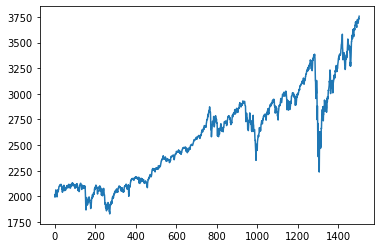

In [186]:
# Visualising the results

real_stock_price= pd.Series(test_set[waitingDays:,0])
real_stock_price.plot()

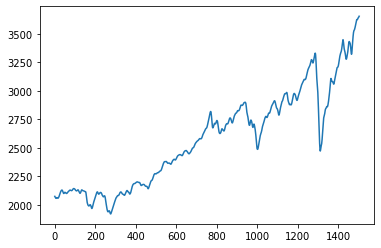

In [185]:

predicted_stock_price= pd.Series(predicted_stock_price)
predicted_stock_price.plot()

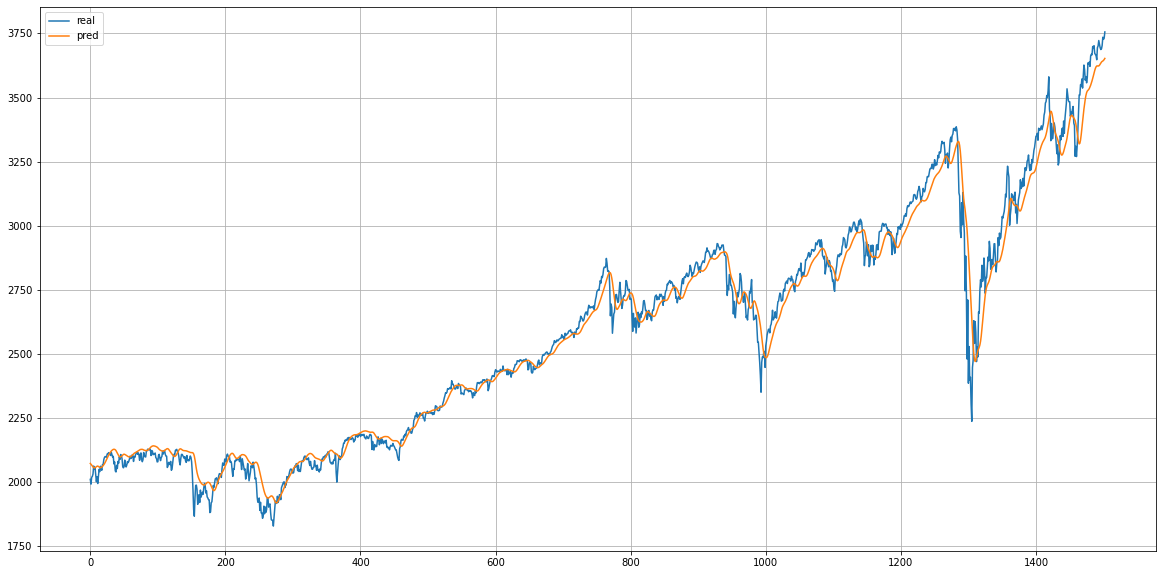

In [181]:
#real_stock_price.plot()
#predicted_stock_price.plot()
aDf= pd.DataFrame()
aDf['real']= real_stock_price
aDf['pred']= predicted_stock_price
aDf.plot(grid=True, figsize=(20,10))

In [217]:
ma= real_stock_price.rolling(window=waitingDays).mean()
maCenter= real_stock_price.rolling(window=waitingDays, center=True).mean()

In [218]:
aDf['ma']= ma
aDf['maCenter']= maCenter

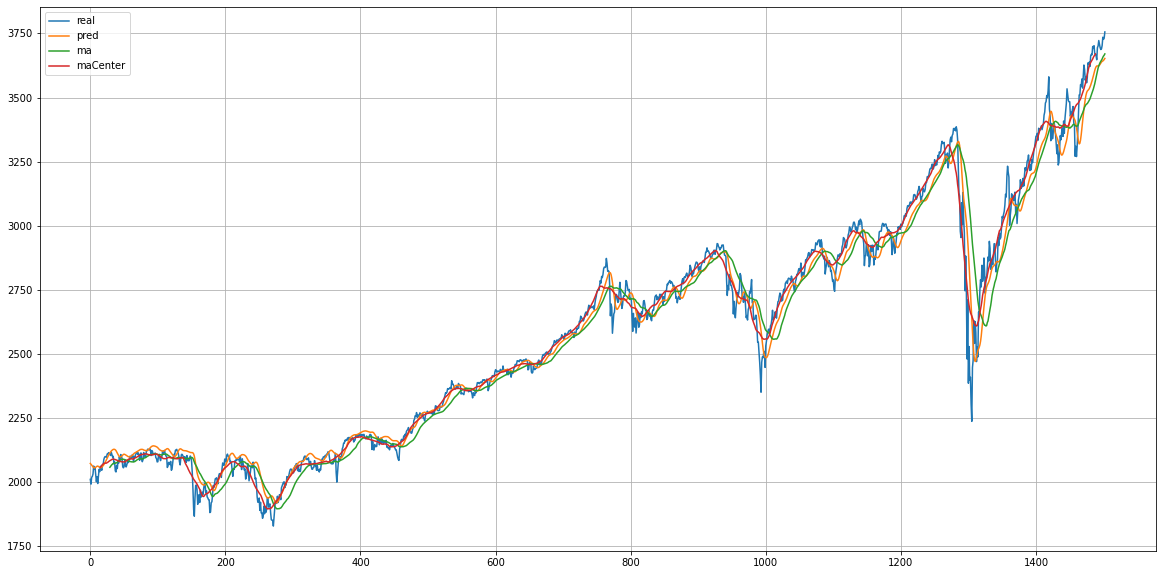

In [221]:
aDf.plot(grid=True, figsize=(20,10))

In [222]:
aDf.corr()

,real,pred,ma,maCenter
real,1.000000,0.990733,0.980569,0.994716
pred,0.990733,1.000000,0.993724,0.995087
ma,0.980569,0.993724,1.000000,0.988523
maCenter,0.994716,0.995087,0.988523,1.000000


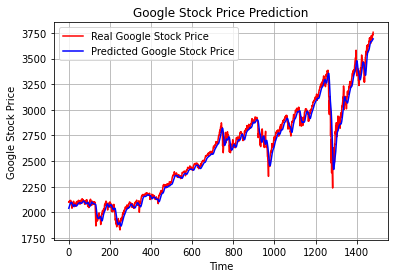

In [139]:

# Visualising the results

real_stock_price= test_set
plt.plot(real_stock_price[waitingDays:], color = 'red', label = 'Real Google Stock Price')

plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')

plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.grid(True)
plt.show()